# IRM Parameterisation of LlammaLend Markets

This implementation is quick and dirty illustrative implementation based on [Bertucci et al. (2024)](https://papers.ssrn.com/abstract=4802776). The paper uses a stochastic optimization framework based on utilization dynamics and solving for the optimal utilization using techniques like the Hamilton-Jacobi-Bellman (HJB) equation. 


Step 1: Define Utilization Dynamics
- The drift term describes the deterministic evolution of utilization based on borrower and lender sensitivities. 
- The volatility term captures random market fluctuations.

In [ ]:
import numpy as np

def drift(U, r, A, C, r0, r1):
    """
    Drift term for utilization dynamics.
    U: Utilization ratio.
    r: Interest rate.
    A: Borrower sensitivity.
    C: Lender sensitivity.
    r0: Borrower alternative rate.
    r1: Lender alternative rate.
    """
    return A * U * (r0 - r) - C * (1 - U) * (r - r1)

def volatility(U, r, sigma_const):
    """
    Volatility term for utilization dynamics.
    U: Utilization ratio.
    r: Interest rate.
    sigma_const: Volatility constant.
    """
    return sigma_const * U


Step 2: Define the Interest Rate Model
- Models $𝑟(𝑈)$ the interest rate as a function of utilization.
- Semi-log MP is chosen for its smooth rate adjustments at varying utilizations.

In [3]:
def interest_rate_model(U, a, b):
    """
    Semi-log MP interest rate model.
    U: Utilization ratio.
    a: Base rate.
    b: Sensitivity parameter.
    """
    return a + b * np.log(U) if U > 0 else np.inf


Step 3: Simulate Utilization Dynamics
- Simulates the stochastic evolution of $𝑈_𝑡$ using the drift and volatility terms.
- Ensures $U_t$ remains within the valid range [0, 1].

In [4]:
def simulate_utilization(U0, T, dt, rate_model, A, C, r0, r1, sigma_const):
    """
    Simulate utilization dynamics using a stochastic differential equation.
    U0: Initial utilization.
    T: Total simulation time.
    dt: Time step.
    rate_model: Function defining the interest rate as a function of U.
    A, C, r0, r1, sigma_const: Model parameters.
    """
    n_steps = int(T / dt)
    U = U0
    path = [U0]
    for _ in range(n_steps):
        dW = np.random.normal(0, np.sqrt(dt))  # Brownian motion increment
        r = rate_model(U)  # Interest rate at current utilization
        dU = drift(U, r, A, C, r0, r1) * dt + volatility(U, r, sigma_const) * dW
        U = max(0, min(1, U + dU))  # Ensure U stays in [0, 1]
        path.append(U)
    return np.array(path)


Step 4: Define the Reward Function
- Balances revenue $r(U)$ against penalties for deviating from $U_target$



In [ ]:
def reward_function(U, r, U_target, lambda_penalty):
    """
    Reward function for optimization.
    U: Utilization ratio.
    r: Interest rate.
    U_target: Target utilization (can be dynamically set).
    lambda_penalty: Penalty weight for deviation from U_target.
    """
    revenue = r * U
    penalty = lambda_penalty * (U - U_target)**2
    return revenue - penalty

Step 5: Approximate HJB 
- Iterates over utilizations and interest rates to approximate the solution to the HJB equation.
- Selects the interest rate that maximizes total reward.


In [ ]:
def solve_hjb(U_range, rate_model, A, C, r0, r1, sigma_const, lambda_penalty, U_target):
    """
    Approximate solution to the HJB equation.
    U_range: Discretized utilization range.
    rate_model: Interest rate model.
    A, C, r0, r1, sigma_const: Model parameters.
    lambda_penalty: Penalty weight.
    U_target: Target utilization (used in reward calculation).
    """
    optimal_rates = []
    for U in U_range:
        best_rate = None
        max_reward = -np.inf
        for r in np.linspace(0.01, 1, 50):  # Test interest rates
            # Calculate components of the HJB equation
            reward = reward_function(U, r, U_target, lambda_penalty)
            drift_term = drift(U, r, A, C, r0, r1)  # Expected rate of change of U
            volatility_term = volatility(U, r, sigma_const)
            stability_term = -0.5 * volatility_term**2  # Variance penalty

            # Combine all terms into the total reward
            total_reward = reward + drift_term + stability_term

            # Check if this rate yields the maximum reward
            if total_reward > max_reward:
                max_reward = total_reward
                best_rate = r
        
        # Append the optimal rate and reward for this utilization level
        optimal_rates.append((U, best_rate, max_reward))
    
    return optimal_rates

Step 6: Validate optimal rates against simulated paths 

- Validates the effectiveness of $r ∗ (U)$ by simulating utilization dynamics under the derived rates.

In [7]:
def validate_optimal_rates(optimal_rates, U0, T, dt, A, C, r0, r1, sigma_const):
    U_path = [U0]
    for t in range(int(T / dt)):
        U = U_path[-1]
        r = next((rate for u, rate, _ in optimal_rates if np.isclose(U, u, atol=0.01)), None)
        if r is None:
            continue
        dW = np.random.normal(0, np.sqrt(dt))
        dU = drift(U, r, A, C, r0, r1) * dt + volatility(U, r, sigma_const) * dW
        U = max(0, min(1, U + dU))
        U_path.append(U)
    return np.array(U_path)

Helper for plotting 


In [8]:
import matplotlib.pyplot as plt 
def plot_results(U_range, optimal_rates, utilization_path, U_target):
    rates = [rate for _, rate, _ in optimal_rates]
    plt.figure(figsize=(12, 6))

    # Optimal Rates
    plt.subplot(1, 2, 1)
    plt.plot(U_range, rates, label="Optimal Interest Rates")
    plt.axhline(U_target, color="r", linestyle="--", label="Target Utilization")
    plt.title("Optimal Interest Rates vs. Utilization")
    plt.xlabel("Utilization (U)")
    plt.ylabel("Interest Rate (r)")
    plt.legend()
    plt.grid()

    # Utilization Path
    plt.subplot(1, 2, 2)
    plt.plot(utilization_path, label="Utilization Path")
    plt.axhline(U_target, color="r", linestyle="--", label="Target Utilization")
    plt.title("Simulated Utilization Path")
    plt.xlabel("Time Steps")
    plt.ylabel("Utilization (U)")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

### Demostative experiment

In [ ]:
# Parameters
U0 = 0.4           # Initial utilization
T = 10             # Total simulation time
dt = 0.01          # Time step
U_target = None     # Target utilization
r0 = 0.1           # Borrower's alternative rate
r1 = 0.05          # Lender's alternative rate
A = 1.0            # Borrower sensitivity
C = 1.0            # Lender sensitivity
sigma_const = 0.1  # Volatility constant
lambda_penalty = 10  # Penalty weight for deviation from target

# Define Utilization Range
U_range = np.linspace(0.1, 0.9, 50)

# Solve for Optimal Rates
optimal_rates = solve_hjb(U_range, interest_rate_model, A, C, r0, r1, sigma_const, U_target, lambda_penalty)

# Simulate Utilization Dynamics
utilization_path = validate_optimal_rates(optimal_rates, U0, T, dt, A, C, r0, r1, sigma_const)

# Plot Results
plot_results(U_range, optimal_rates, utilization_path, U_target)

# Print Summary
print("Optimal Rates for Utilization Range:")
for U, rate, reward in optimal_rates:
    print(f"Utilization: {U:.2f}, Optimal Rate: {rate:.4f}, Reward: {reward:.4f}")

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

Optimal Utilization: 0.71


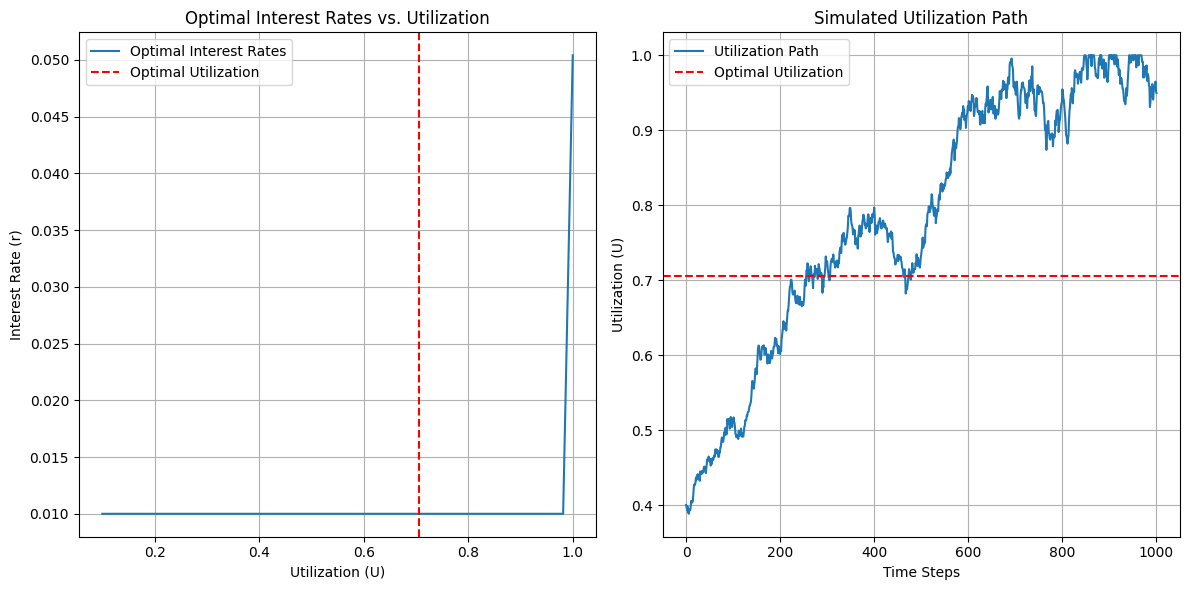

Optimal Rates for Utilization Range:
Utilization: 0.10, Optimal Rate: 0.0100, Reward: -3.5540
Utilization: 0.12, Optimal Rate: 0.0100, Reward: -3.3359
Utilization: 0.14, Optimal Rate: 0.0100, Reward: -3.1246
Utilization: 0.16, Optimal Rate: 0.0100, Reward: -2.9200
Utilization: 0.17, Optimal Rate: 0.0100, Reward: -2.7221
Utilization: 0.19, Optimal Rate: 0.0100, Reward: -2.5310
Utilization: 0.21, Optimal Rate: 0.0100, Reward: -2.3466
Utilization: 0.23, Optimal Rate: 0.0100, Reward: -2.1690
Utilization: 0.25, Optimal Rate: 0.0100, Reward: -1.9981
Utilization: 0.27, Optimal Rate: 0.0100, Reward: -1.8340
Utilization: 0.28, Optimal Rate: 0.0100, Reward: -1.6767
Utilization: 0.30, Optimal Rate: 0.0100, Reward: -1.5260
Utilization: 0.32, Optimal Rate: 0.0100, Reward: -1.3822
Utilization: 0.34, Optimal Rate: 0.0100, Reward: -1.2451
Utilization: 0.36, Optimal Rate: 0.0100, Reward: -1.1147
Utilization: 0.38, Optimal Rate: 0.0100, Reward: -0.9911
Utilization: 0.39, Optimal Rate: 0.0100, Reward: -0

In [ ]:
# Adjusted Main Script to Derive Optimal Utilization (U_optimal)

import numpy as np
import matplotlib.pyplot as plt

# --- Core Functions ---
def drift(U, r, A, C, r0, r1):
    return A * U * (r0 - r) - C * (1 - U) * (r - r1)

def volatility(U, r, sigma_const):
    return sigma_const * U

def interest_rate_model(U, a, b):
    return a + b * np.log(U) if U > 0 else np.inf

def reward_function(U, r, U_target, lambda_penalty):
    """
    Reward function for optimization.
    U: Utilization ratio.
    r: Interest rate.
    U_target: Target utilization (can be dynamically set).
    lambda_penalty: Penalty weight for deviation from U_target.
    """
    revenue = r * U
    penalty = lambda_penalty * (U - U_target)**2
    return revenue - penalty


# --- Solve HJB Approximation ---
def solve_hjb(U_range, rate_model, A, C, r0, r1, sigma_const, lambda_penalty, U_target):
    """
    Approximate solution to the HJB equation.
    U_range: Discretized utilization range.
    rate_model: Interest rate model.
    A, C, r0, r1, sigma_const: Model parameters.
    lambda_penalty: Penalty weight.
    U_target: Target utilization (used in reward calculation).
    """
    optimal_rates = []
    for U in U_range:
        best_rate = None
        max_reward = -np.inf
        for r in np.linspace(0.01, 1, 50):  # Test interest rates
            # Calculate components of the HJB equation
            reward = reward_function(U, r, U_target, lambda_penalty)
            drift_term = drift(U, r, A, C, r0, r1)  # Expected rate of change of U
            volatility_term = volatility(U, r, sigma_const)
            stability_term = -0.5 * volatility_term**2  # Variance penalty

            # Combine all terms into the total reward
            total_reward = reward + drift_term + stability_term

            # Check if this rate yields the maximum reward
            if total_reward > max_reward:
                max_reward = total_reward
                best_rate = r
        
        # Append the optimal rate and reward for this utilization level
        optimal_rates.append((U, best_rate, max_reward))
    
    return optimal_rates



# --- Validate Optimal Rates ---
def validate_optimal_rates(optimal_rates, U0, T, dt, A, C, r0, r1, sigma_const):
    U_path = [U0]
    for t in range(int(T / dt)):
        U = U_path[-1]
        r = next((rate for u, rate, _ in optimal_rates if np.isclose(U, u, atol=0.01)), None)
        if r is None:
            continue
        dW = np.random.normal(0, np.sqrt(dt))
        dU = drift(U, r, A, C, r0, r1) * dt + volatility(U, r, sigma_const) * dW
        U = max(0, min(1, U + dU))
        U_path.append(U)
    return np.array(U_path)

# --- Visualization ---
def plot_results(U_range, optimal_rates, utilization_path, U_optimal):
    rates = [rate for _, rate, _ in optimal_rates]
    plt.figure(figsize=(12, 6))

    # Optimal Rates
    plt.subplot(1, 2, 1)
    plt.plot(U_range, rates, label="Optimal Interest Rates")
    plt.axvline(U_optimal, color="r", linestyle="--", label="Optimal Utilization")
    plt.title("Optimal Interest Rates vs. Utilization")
    plt.xlabel("Utilization (U)")
    plt.ylabel("Interest Rate (r)")
    plt.legend()
    plt.grid()

    # Utilization Path
    plt.subplot(1, 2, 2)
    plt.plot(utilization_path, label="Utilization Path")
    plt.axhline(U_optimal, color="r", linestyle="--", label="Optimal Utilization")
    plt.title("Simulated Utilization Path")
    plt.xlabel("Time Steps")
    plt.ylabel("Utilization (U)")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Parameters
U0 = 0.4           # Initial utilization
T = 10             # Total simulation time
dt = 0.01          # Time step
r0 = 0.1           # Borrower's alternative rate
r1 = 0.05          # Lender's alternative rate
A = 1.0            # Borrower sensitivity
C = 1.0            # Lender sensitivity
sigma_const = 0.1  # Volatility constant
lambda_penalty = 10  # Penalty weight for deviation from target

# Define Utilization Range
U_range = np.linspace(0.1, 1, 50)
U_target = 0.7  # Example initial target

# Solve for Optimal Rates
optimal_rates = solve_hjb(U_range, interest_rate_model, A, C, r0, r1, sigma_const, lambda_penalty, U_target)


# Identify Optimal Utilization
U_optimal = max(optimal_rates, key=lambda x: x[2])[0]  # Utilization with max reward
print(f"Optimal Utilization: {U_optimal:.2f}")

# Simulate Utilization Dynamics
utilization_path = validate_optimal_rates(optimal_rates, U0, T, dt, A, C, r0, r1, sigma_const)

# Plot Results
plot_results(U_range, optimal_rates, utilization_path, U_optimal)

# Print Summary
print("Optimal Rates for Utilization Range:")
for U, rate, reward in optimal_rates:
    print(f"Utilization: {U:.2f}, Optimal Rate: {rate:.4f}, Reward: {reward:.4f}")


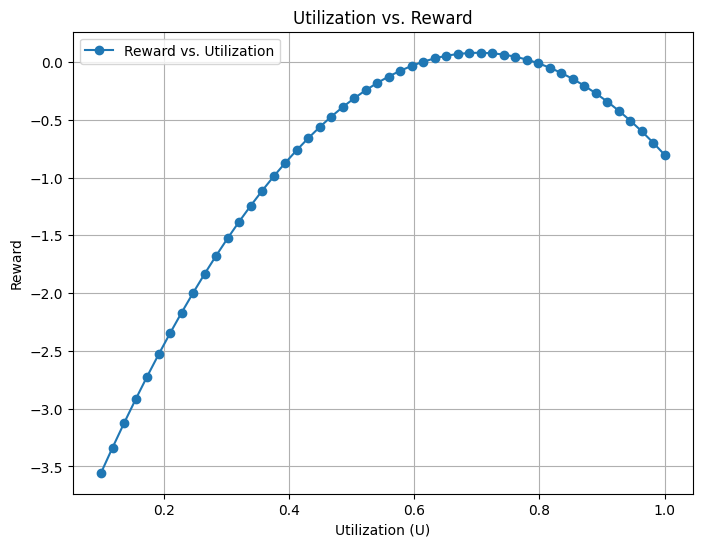

In [23]:
# Plot Utilization vs. Reward based on the Optimal Rates

def plot_utilization_vs_reward(optimal_rates):
    """
    Plot Utilization vs. Reward based on the solved HJB approximation.
    optimal_rates: List of tuples (U, optimal_rate, reward).
    """
    utilizations = [entry[0] for entry in optimal_rates]
    rewards = [entry[2] for entry in optimal_rates]

    plt.figure(figsize=(8, 6))
    plt.plot(utilizations, rewards, label="Reward vs. Utilization", marker='o')
    plt.title("Utilization vs. Reward")
    plt.xlabel("Utilization (U)")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot Utilization vs. Reward using the computed optimal_rates
plot_utilization_vs_reward(optimal_rates)
